# Data Acquisition

This dataset has been taken from Kaggle. 
This dataset contains vehicle dataset - attribute, model, accident details, etc along with policy details - policy type, tenure etc. The target is to detect if a claim application is fraudulent or not - FraudFound_P


Information on the fields:

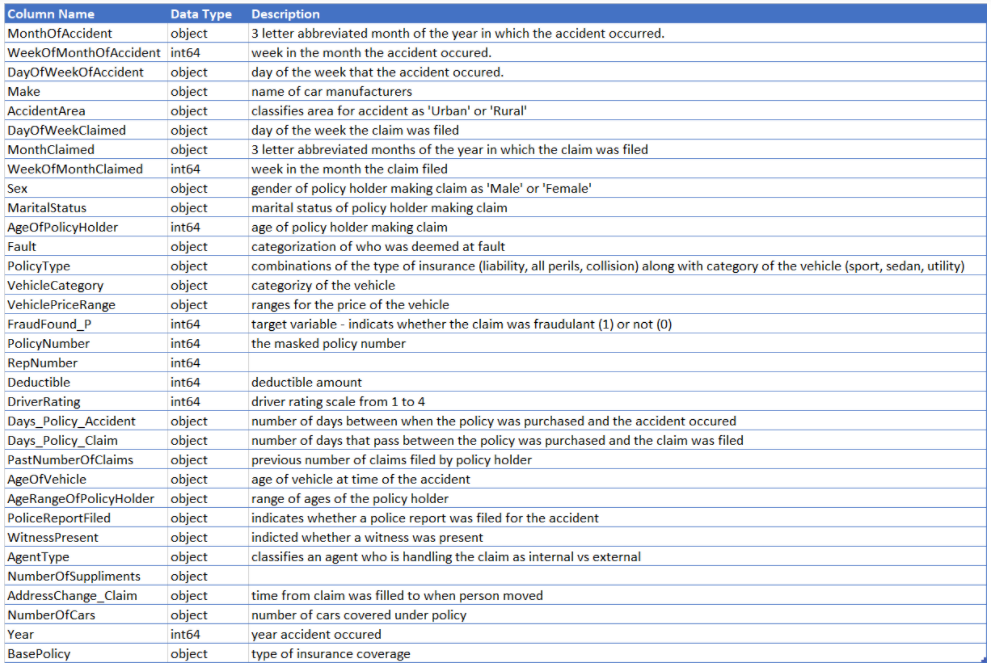

In [101]:
#from google.colab import files
#upload = files.upload()

from IPython.display import Image
Image(filename='../Data/DataDictionary.PNG')
#Image(filename='DataDictionary.PNG')

#### Step 1: Set up

In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
! pip install missingno
! pip install imblearn
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedShuffleSplit
#!pip3 install yellowbrick
#from yellowbrick.target import ClassBalance
from imblearn.over_sampling import (
SMOTE, ADASYN
)
from imblearn.over_sampling import (
    RandomOverSampler,
)
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTEENN

#### Step 2: Get the data

In [103]:
fraud = pd.read_csv("../Data/input_dataset.csv")
#fraud = pd.read_csv("input_dataset.csv")

#### Step 3: Take a Quick Look at the Data Structure

In [104]:
fraud.head()

,MonthOfAccident,WeekOfMonthOfAccident,DayOfWeekOfAccident,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,AgeOfPolicyHolder,Fault,PolicyType,VehicleCategory,VehiclePriceRange,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeRangeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,27.0,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,NaN,3 years,26 to 30,No,No,External,NaN,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,NaN,6 years,31 to 35,Yes,No,External,NaN,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,NaN,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65.0,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27.0,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,NaN,5 years,31 to 35,No,No,External,NaN,no change,1 vehicle,1994,Collision


In [105]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MonthOfAccident         15420 non-null  object 
 1   WeekOfMonthOfAccident   15420 non-null  int64  
 2   DayOfWeekOfAccident     15420 non-null  object 
 3   Make                    15420 non-null  object 
 4   AccidentArea            15420 non-null  object 
 5   DayOfWeekClaimed        15419 non-null  object 
 6   MonthClaimed            15419 non-null  object 
 7   WeekOfMonthClaimed      15420 non-null  int64  
 8   Sex                     15420 non-null  object 
 9   MaritalStatus           15420 non-null  object 
 10  AgeOfPolicyHolder       15100 non-null  float64
 11  Fault                   15420 non-null  object 
 12  PolicyType              15420 non-null  object 
 13  VehicleCategory         15420 non-null  object 
 14  VehiclePriceRange       15420 non-null

In [106]:
fraud.describe()

,WeekOfMonthOfAccident,WeekOfMonthClaimed,AgeOfPolicyHolder,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15100.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,40.700728,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,12.308954,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,16.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,39.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,49.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


#### Step 4: Stratefied Split into train, validation and test to maintain the ratio

In [107]:
#fraud_train, fraud_val_test = train_test_split(fraud, test_size=0.3, random_state=5)
#fraud_val, fraud_test = train_test_split(fraud_val_test, test_size=0.5, random_state=5)

split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=5)
for train_index1, test_index1 in split1.split(fraud, fraud["FraudFound_P"]):
    fraud_train = fraud.loc[train_index1]
    fraud_val_test = fraud.loc[test_index1]

fraud_val_test.reset_index(drop=True, inplace=True)
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=5)
for train_index2, test_index2 in split2.split(fraud_val_test, fraud_val_test["FraudFound_P"]):
    fraud_val = fraud_val_test.loc[train_index2]
    fraud_test = fraud_val_test.loc[test_index2]

In [108]:
#final split dataframes
fraud_train.reset_index(drop=True, inplace=True) 
fraud_val.reset_index(drop=True, inplace=True) 
fraud_test.reset_index(drop=True, inplace=True)

# Data Preparation

In [109]:
fraud = fraud_train.copy()

#fraud_labels = fraud["FraudFound_P"].copy()
#fraud = fraud.drop("FraudFound_P", axis=1)

#### Step 1. Dealing with missing data

In [110]:
# Missing value statistics

def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [111]:
# Missing values statistics
miss_values = missing_values(fraud)
miss_values.head(20)

Dataframe has 33 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
NumberOfSuppliments,4959,45.9
PastNumberOfClaims,3043,28.2
AgeOfPolicyHolder,220,2.0
Days_Policy_Accident,38,0.4
DayOfWeekClaimed,1,0.0
MonthClaimed,1,0.0
Days_Policy_Claim,1,0.0


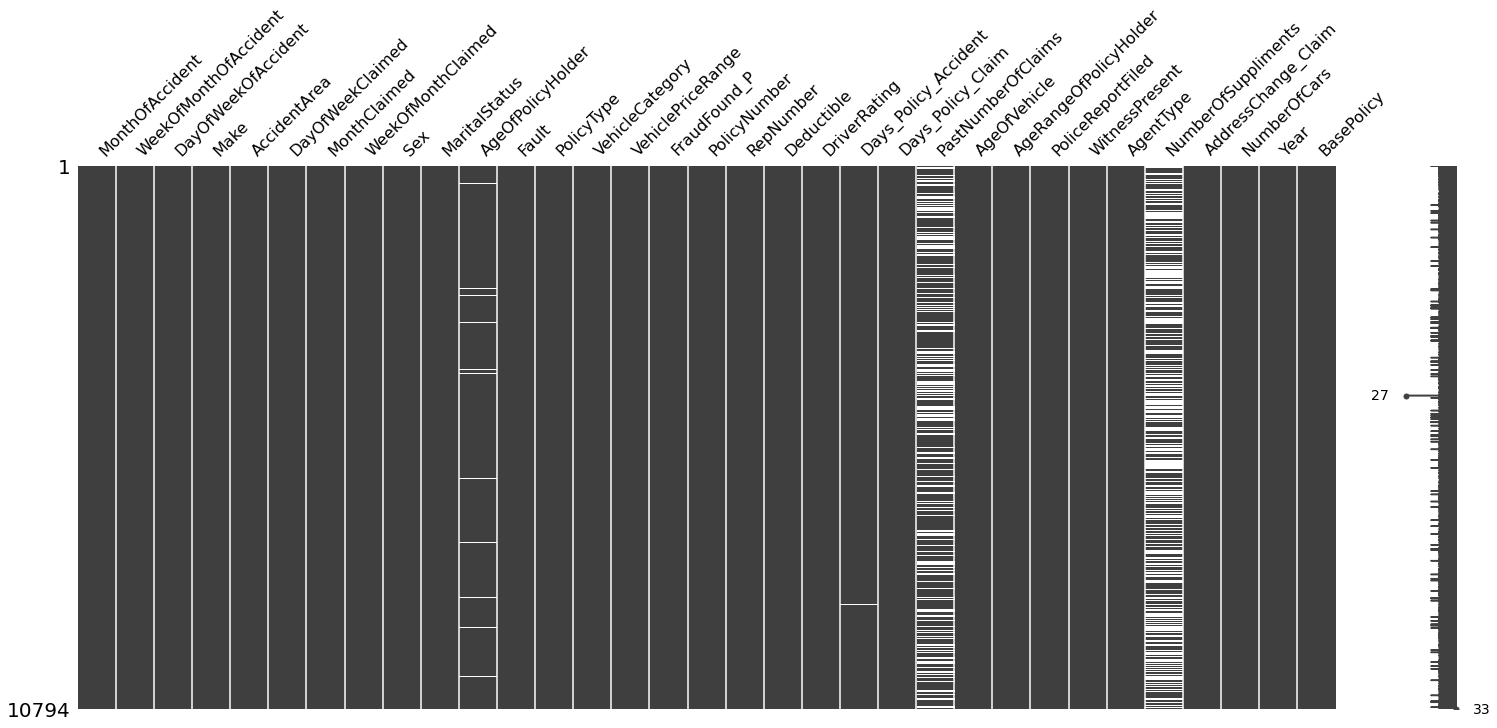

In [112]:
# Plot correlation heatmap of missingness
msno.matrix(fraud);

#### Drop missing values
If a column has 70% of its rows missing then we remove the column

In [113]:
temp = [i for i in fraud.count() < len(fraud) * 0.30]
fraud.drop(fraud.columns[temp], axis=1, inplace=True)

Drop the rows with less missing values

In [114]:
fraud.dropna(subset = ["DayOfWeekClaimed", "MonthClaimed", "Days_Policy_Claim"], inplace=True)

drop missing rows in the target variable

In [115]:
fraud.dropna(subset = ["FraudFound_P"], inplace=True)

#### Step 2. Data preprocessing and Cleaning data

In [116]:
fraud['AgeRangeOfPolicyHolder'] = fraud['AgeRangeOfPolicyHolder'].str.strip()

drop columns which would not add much significance to the model

In [117]:
# The policy number is masked, and has been replaced with ordered integers. hence can be dropped. It also has a high correlation with Year.
# PolicyType is a combination of 2 ariables, both of which are present as individual columns. Hence can be dropped, but we will keep it to test interactions
fraud.drop(columns = ["PolicyNumber"], inplace=True)

convert Yes/No vaiables to 1/0 and change their data type

In [118]:
fraud['PoliceReportFiled'] = fraud['PoliceReportFiled'].map({'Yes': 1, 'No': 0}).astype('int64')
fraud['WitnessPresent'] = fraud['WitnessPresent'].map({'Yes': 1, 'No': 0}).astype('int64')

convert the months in text to numerical months

In [119]:
fraud['MonthOfAccident'] = pd.to_datetime(fraud.MonthOfAccident, format='%b').dt.month
fraud['MonthClaimed'] = pd.to_datetime(fraud.MonthClaimed, format='%b').dt.month

#### Step 3. Outlier detection

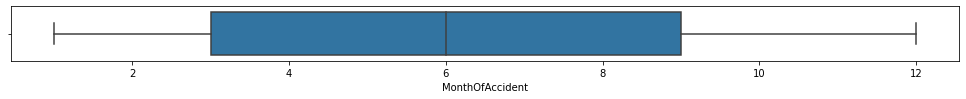

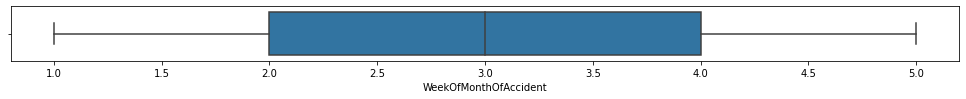

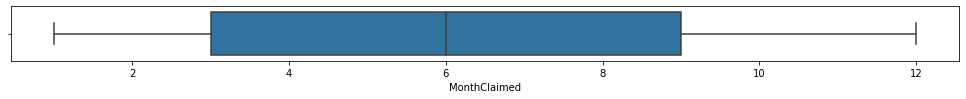

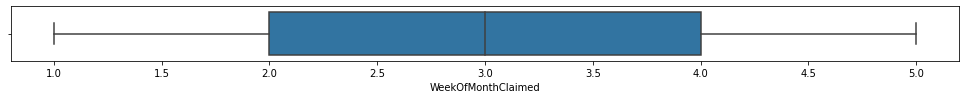

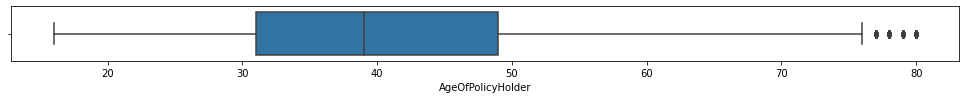

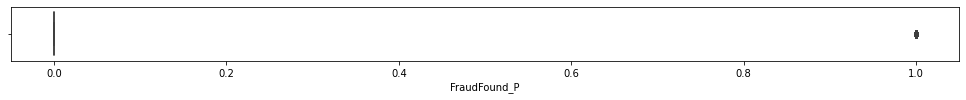

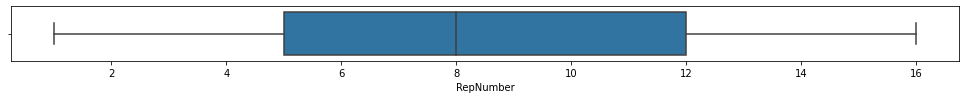

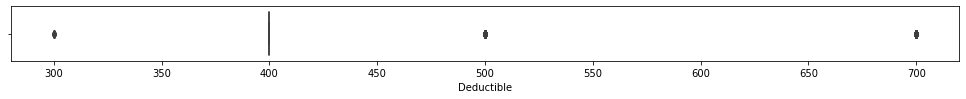

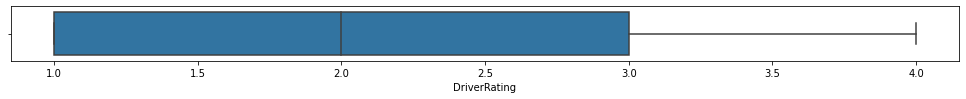

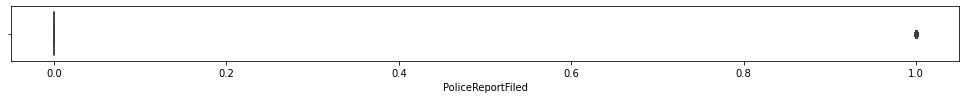

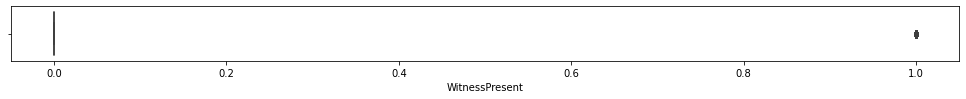

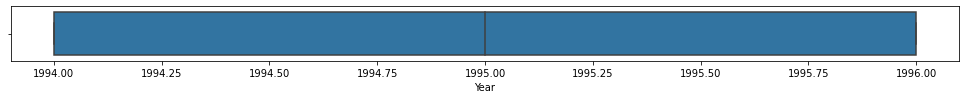

In [120]:
df1=fraud.select_dtypes(exclude=['object'])

for column in df1:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df1, x=column)

From this, we only find AgeOfPolicyHolder to be a potential outlier.

In [121]:
# identify outliers
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()
fraud['AgeOfPolicyHolder'].fillna(fraud['AgeRangeOfPolicyHolder'].str[-2:].astype('int64'), inplace=True)
yhat = lof.fit_predict(pd.DataFrame(fraud['AgeOfPolicyHolder']))

# select all rows that are not outliers
fraud = fraud[yhat != -1]
fraud = fraud

#### create a custom transformer combining all above steps

In [122]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, ):
        pass# no *args or **kargs      
    def fit(self, X, y=None):
        
        return self
    def transform(self, X): 
        
        # If a column has 70% of its rows missing then we remove the column
        temp = [i for i in X.count() < len(X) * 0.30]
        X.drop(X.columns[temp], axis=1, inplace=True)
        
        X.dropna(subset = ["DayOfWeekClaimed", "MonthClaimed", "Days_Policy_Claim"], inplace=True)
        X.dropna(subset = ["FraudFound_P"], inplace=True)        
        X['AgeRangeOfPolicyHolder'] = X['AgeRangeOfPolicyHolder'].str.strip()        
        X.drop(columns = ["PolicyNumber"], inplace=True)        
        X['PoliceReportFiled'] = X['PoliceReportFiled'].map({'Yes': 1, 'No': 0}).astype('int64')
        X['WitnessPresent'] = X['WitnessPresent'].map({'Yes': 1, 'No': 0}).astype('int64')
        X['MonthOfAccident'] = pd.to_datetime(X.MonthOfAccident, format='%b').dt.month
        X['MonthClaimed'] = pd.to_datetime(X.MonthClaimed, format='%b').dt.month
        lof = LocalOutlierFactor()
        X['AgeOfPolicyHolder'].fillna(X['AgeRangeOfPolicyHolder'].str[-2:].astype('int64'), inplace=True)
        yhat = lof.fit_predict(pd.DataFrame(X['AgeOfPolicyHolder']))
        # select all rows that are not outliers
        X = X[yhat != -1]         
            
        return X.reset_index(drop=True)

#### Step 4. Feature engineering

 - Most of the numerical variables have already been binned in the dataset, hence, we do not need to implement binning
 - Variables like 'PolicyType' which represents interactions between 2 other variables have been preserved to heck feature aggregations
 - Variables are divided into numerical and categorical variables and are encoded differently (0 for numerical and 'none' for categorical)

In [123]:
fraud.reset_index(drop=True, inplace=True)

fraud_labels = fraud["FraudFound_P"].copy()
fraud = fraud.drop("FraudFound_P", axis=1)

#### Fill in missing values depending upon column
- Days_Policy_Accident - is a categorical column and null values mean that there are no days between policy purchase and accident. so fill as 'none'
- PastNumberOfClaims- is a categorical column and null values mean that there are no pas claims, so fill as 'none'
- NumberOfSuppliments - is a categorical column and null values mean that there are no suppliments, fill as 'none'
- AgeOfPolicyHolder - signifies the missing age of the driver, but we will replace this with the upper value from the columns 'Age range of the policy holder'

#### Segregate to numerical and categorical data

A. Numerical

In [124]:
fraud_num = fraud.select_dtypes(include=[np.number])
fraud_num

,MonthOfAccident,WeekOfMonthOfAccident,MonthClaimed,WeekOfMonthClaimed,AgeOfPolicyHolder,RepNumber,Deductible,DriverRating,PoliceReportFiled,WitnessPresent,Year
0,2,3,2,3,39.0,6,400,2,0,0,1995
1,5,2,5,2,62.0,11,400,2,0,0,1996
2,12,1,12,2,24.0,15,400,3,0,0,1994
3,4,1,4,1,28.0,4,400,3,0,0,1994
4,3,4,3,4,53.0,9,400,3,0,0,1994
...,...,...,...,...,...,...,...,...,...,...,...
10686,12,4,12,4,56.0,1,400,4,0,0,1994
10687,4,1,4,2,46.0,13,400,3,0,0,1995
10688,8,1,8,2,52.0,2,400,2,0,0,1995
10689,4,3,4,3,30.0,7,400,3,0,0,1996


In [125]:
imputer = SimpleImputer(strategy="constant", fill_value=0)

In [126]:
imputer.fit(fraud_num)

SimpleImputer(fill_value=0, strategy='constant')

In [127]:
imputer.statistics_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

B. Categorical

In [128]:
fraud_cat = fraud.select_dtypes(include=[object])
fraud_cat

,DayOfWeekOfAccident,Make,AccidentArea,DayOfWeekClaimed,Sex,MaritalStatus,Fault,PolicyType,VehicleCategory,VehiclePriceRange,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeRangeOfPolicyHolder,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Wednesday,Honda,Urban,Monday,Male,Married,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,more than 30,more than 30,NaN,more than 7,36 to 40,External,NaN,no change,3 to 4,Collision
1,Monday,Toyota,Urban,Tuesday,Male,Married,Third Party,Sedan - Collision,Sedan,20000 to 29000,more than 30,more than 30,1,more than 7,51 to 65,External,1 to 2,no change,1 vehicle,Collision
2,Tuesday,Toyota,Urban,Friday,Male,Married,Policy Holder,Sedan - Liability,Sport,20000 to 29000,more than 30,more than 30,2 to 4,5 years,26 to 30,External,3 to 5,no change,1 vehicle,Liability
3,Saturday,Mazda,Urban,Wednesday,Male,Single,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,more than 30,more than 30,NaN,6 years,31 to 35,External,more than 5,no change,1 vehicle,Collision
4,Wednesday,Dodge,Urban,Friday,Male,Married,Third Party,Sedan - Collision,Sedan,30000 to 39000,NaN,8 to 15,1,more than 7,41 to 50,External,1 to 2,no change,1 vehicle,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10686,Thursday,Honda,Urban,Friday,Male,Married,Third Party,Sedan - All Perils,Sedan,20000 to 29000,more than 30,more than 30,1,7 years,51 to 65,External,more than 5,no change,1 vehicle,All Perils
10687,Thursday,Chevrolet,Urban,Monday,Male,Single,Policy Holder,Utility - All Perils,Utility,more than 69000,more than 30,more than 30,2 to 4,7 years,41 to 50,External,3 to 5,4 to 8 years,3 to 4,All Perils
10688,Saturday,Chevrolet,Rural,Wednesday,Male,Married,Policy Holder,Sedan - Liability,Sport,20000 to 29000,more than 30,more than 30,NaN,7 years,41 to 50,External,1 to 2,no change,1 vehicle,Liability
10689,Saturday,Honda,Urban,Thursday,Female,Single,Third Party,Sedan - Collision,Sedan,20000 to 29000,more than 30,more than 30,2 to 4,5 years,31 to 35,External,more than 5,no change,1 vehicle,Collision


In [129]:
imputer = SimpleImputer(strategy="constant", fill_value='none')

In [130]:
imputer.fit(fraud_cat)

SimpleImputer(fill_value='none', strategy='constant')

In [131]:
imputer.statistics_

array(['none', 'none', 'none', 'none', 'none', 'none', 'none', 'none',
       'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none',
       'none', 'none', 'none', 'none'], dtype=object)

In [132]:
cat_new = imputer.transform(fraud_cat)
fraud_cat = pd.DataFrame(cat_new, columns=fraud_cat.columns,
                          index=fraud.index)

#### Encoding

In [133]:
ordinal_encoder = OrdinalEncoder(categories=[
    ['Sunday','Monday','Monday','Tuesday','Wednesday', 'Thursday','Friday', 'Saturday'],
    ['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda','Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson','Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'],
    ['Rural', 'Urban'],
    ['Sunday','Monday','Monday','Tuesday','Wednesday', 'Thursday','Friday', 'Saturday'],
    ['Female', 'Male'], 
    ['Single','Married', 'Divorced', 'Widow'],
    ['Policy Holder', 'Third Party'],
    ['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability','Sport - All Perils', 'Sport - Collision', 'Sport - Liability','Utility - All Perils', 'Utility - Collision','Utility - Liability'],
    ['Sedan', 'Sport', 'Utility'],
    ['less than 20000','20000 to 29000', '30000 to 39000', '40000 to 59000','60000 to 69000', 'more than 69000'],
    ['none', '1 to 7','8 to 15', '15 to 30','more than 30'],
    ['8 to 15','15 to 30', 'more than 30'],
    ['none','1', '2 to 4', 'more than 4'],
    ['new','2 years', '3 years', '4 years', '5 years', '6 years', '7 years','more than 7'],
    ['16 to 17', '18 to 20', '21 to 25', '26 to 30', '31 to 35','36 to 40', '41 to 50', '51 to 65', 'over 65'],
    ['External', 'Internal'],
    ['none','1 to 2', '3 to 5', 'more than 5'],
    ['no change','under 6 months','1 year', '2 to 3 years', '4 to 8 years'],
    ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'],
    ['All Perils', 'Collision', 'Liability']
])

fraud_cat = pd.DataFrame(ordinal_encoder.fit_transform(fraud_cat.loc[:,['DayOfWeekOfAccident', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePriceRange', 'Days_Policy_Accident', 
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeRangeOfPolicyHolder','AgentType', 
        'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']]), columns = fraud_cat.columns)

In [134]:
ordinal_encoder.categories_

[array(['Sunday', 'Monday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
        'Friday', 'Saturday'], dtype=object),
 array(['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda',
        'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson',
        'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'],
       dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Sunday', 'Monday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
        'Friday', 'Saturday'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Single', 'Married', 'Divorced', 'Widow'], dtype=object),
 array(['Policy Holder', 'Third Party'], dtype=object),
 array(['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability',
        'Sport - All Perils', 'Sport - Collision', 'Sport - Liability',
        'Utility - All Perils', 'Utility - Collision',
        'Utility - Liability'], dtype=object),
 array(['Sedan', 'Sport', 'Utility'], dtype=object),
 array(['less than 20000',

#### Step 5. Feature scaling

Final check of missing values

In [135]:
sc = StandardScaler()
fraud_numb = sc.fit_transform(fraud_num)
fraud_num = pd.DataFrame(fraud_numb, columns = fraud_num.columns)

fraud = pd.merge(fraud_num, fraud_cat, left_index=True, right_index=True)

In [136]:
fraud.columns

Index(['MonthOfAccident', 'WeekOfMonthOfAccident', 'MonthClaimed',
       'WeekOfMonthClaimed', 'AgeOfPolicyHolder', 'RepNumber', 'Deductible',
       'DriverRating', 'PoliceReportFiled', 'WitnessPresent', 'Year',
       'DayOfWeekOfAccident', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePriceRange', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeRangeOfPolicyHolder',
       'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim',
       'NumberOfCars', 'BasePolicy'],
      dtype='object')

#### Step 6. Transformation pipeline

In [137]:
num_attribs = list(fraud_num)
cat_attribs = list(fraud_cat)

combining the steps of dropping missing values, preprocessing, cleaning together.

In [138]:
common_pipeline = Pipeline([
        ('preprocess', DataPreprocessor())
    ])

Add steps to impute both numerical and categorical along with scaling the numerical variables and encode the catgorical variables

In [139]:
num_pipeline = Pipeline([
        ('imputer_num',  SimpleImputer(strategy="constant", fill_value=0)),
        ('std_scaler', StandardScaler()),
    ])

In [140]:
cat_pipeline = Pipeline([
        ('imputer_cat',  SimpleImputer(strategy="constant", fill_value='none')),
        ('encoder', OrdinalEncoder(categories=[
    ['Sunday','Monday','Monday','Tuesday','Wednesday', 'Thursday','Friday', 'Saturday'],
    ['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda','Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson','Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'],
    ['Rural', 'Urban'],
    ['Sunday','Monday','Monday','Tuesday','Wednesday', 'Thursday','Friday', 'Saturday'],
    ['Female', 'Male'], 
    ['Single','Married', 'Divorced', 'Widow'],
    ['Policy Holder', 'Third Party'],
    ['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability','Sport - All Perils', 'Sport - Collision', 'Sport - Liability','Utility - All Perils', 'Utility - Collision','Utility - Liability'],
    ['Sedan', 'Sport', 'Utility'],
    ['less than 20000','20000 to 29000', '30000 to 39000', '40000 to 59000','60000 to 69000', 'more than 69000'],
    ['none', '1 to 7','8 to 15', '15 to 30','more than 30'],
    ['8 to 15','15 to 30', 'more than 30'],
    ['none','1', '2 to 4', 'more than 4'],
    ['new','2 years', '3 years', '4 years', '5 years', '6 years', '7 years','more than 7'],
    ['16 to 17', '18 to 20', '21 to 25', '26 to 30', '31 to 35','36 to 40', '41 to 50', '51 to 65', 'over 65'],
    ['External', 'Internal'],
    ['none','1 to 2', '3 to 5', 'more than 5'],
    ['no change','under 6 months','1 year', '2 to 3 years', '4 to 8 years'],
    ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'],
    ['All Perils', 'Collision', 'Liability']
])),
    ])

In [141]:
full_pipeline = ColumnTransformer(transformers=[
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs)    
    ])

In [142]:
## Test the pipeline
fraud = fraud_train.copy()
#Used two separate pipelines as the input data structure for both are different
fraud_prepared = common_pipeline.fit_transform(fraud)
fraud_prepared = pd.DataFrame(fraud_prepared, columns = fraud.columns)

fraud_labels = fraud_prepared["FraudFound_P"].copy()
fraud_prepared = fraud_prepared.drop("FraudFound_P", axis=1)

fraud_prepared = full_pipeline.fit_transform(fraud_prepared)

In [143]:
fraud_prepared.shape

(10691, 31)

#### Final train, test and validation dataset

In [144]:
X_train = pd.DataFrame(fraud_prepared, columns = num_attribs+ cat_attribs)
y_train = fraud_labels

train_dataset = pd.merge(X_train, y_train, left_index=True, right_index=True)
train_dataset.to_csv("Fraud_train.csv")

In [145]:
fraud = fraud_val.copy()
#Used two separate pipelines as the input data structure for both are different
fraud_prepared = common_pipeline.fit_transform(fraud)
fraud_prepared = pd.DataFrame(fraud_prepared, columns = fraud.columns)
fraud_labels = fraud_prepared["FraudFound_P"].copy()
fraud_prepared = fraud_prepared.drop("FraudFound_P", axis=1)
fraud_prepared = full_pipeline.fit_transform(fraud_prepared)

X_val = pd.DataFrame(fraud_prepared, columns = num_attribs+ cat_attribs)
y_val = fraud_labels

val_dataset = pd.merge(X_val, y_val, left_index=True, right_index=True)
val_dataset.to_csv("Fraud_val.csv")

In [146]:
fraud = fraud_test.copy()
#Used two separate pipelines as the input data structure for both are different
fraud_prepared = common_pipeline.fit_transform(fraud)
fraud_prepared = pd.DataFrame(fraud_prepared, columns = fraud.columns)
fraud_labels = fraud_prepared["FraudFound_P"].copy()
fraud_prepared = fraud_prepared.drop("FraudFound_P", axis=1)
fraud_prepared = full_pipeline.fit_transform(fraud_prepared)

X_test = pd.DataFrame(fraud_prepared, columns = num_attribs+ cat_attribs)
y_test = fraud_labels

test_dataset = pd.merge(X_test, y_test, left_index=True, right_index=True)
test_dataset.to_csv("Fraud_test.csv")

#### Step 7: Imbalanced data correction

In [147]:
smote_enn = SMOTEENN(random_state=5)
X_train_smoteen, y_train_smoteen = smote_enn.fit_resample(X_train, y_train)

sampledtrain_dataset = pd.merge(X_train_smoteen, y_train_smoteen, left_index=True, right_index=True)
sampledtrain_dataset.to_csv("Fraud_sampledtrain.csv")

#### Step 8. Feature selection

In [148]:
forest_reg = RandomForestRegressor(random_state=5)
forest_reg.fit(X_train_smoteen, y_train_smoteen)

features = pd.DataFrame(list(zip(X_train_smoteen.columns,forest_reg.feature_importances_)), columns = ['predictor', 'feature importance']).sort_values(ascending=False, by = 'feature importance')
features

,predictor,feature importance
30,BasePolicy,0.327914
17,Fault,0.175592
2,MonthClaimed,0.056658
10,Year,0.045176
6,Deductible,0.035139
1,WeekOfMonthOfAccident,0.031883
5,RepNumber,0.024856
24,AgeOfVehicle,0.024843
18,PolicyType,0.023725
20,VehiclePriceRange,0.023366


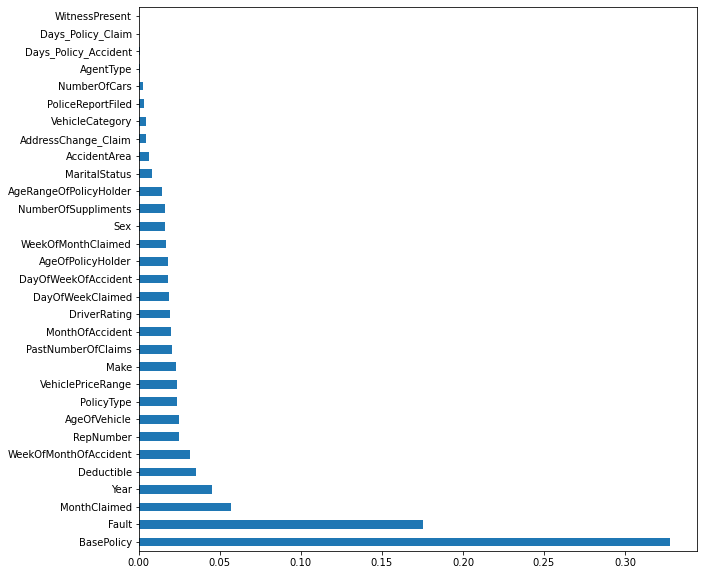

In [149]:
features = pd.Series(forest_reg.feature_importances_, index=X_train_smoteen.columns)
features.nlargest(33).plot(kind='barh',figsize=(10,10))
plt.show()